In [2]:
from database_reading import read_gma_database
from database_writing_utils import extract_experiment_datatable
from database_writing_utils import extract_prior_datatable

In [3]:
db = read_gma_database('../tests/test_002/input/data.gma')
prior_table = extract_prior_datatable(db['APR'])
experiment_table = extract_experiment_datatable(db['datablock_list'], prior_table)

In [4]:
experiment_table

,author,reference,dataset_id,energy,measurement,obstype,reac1,reac2,reac3
0,"P.Salvador-Casti~neira,F.-J",.Hambsch ND2016,8050,1.80,0.495200,xs,"U8(n,f)",,
1,"P.Salvador-Casti~neira,F.-J",.Hambsch ND2016,8050,2.00,0.545100,xs,"U8(n,f)",,
2,"P.Salvador-Casti~neira,F.-J",.Hambsch ND2016,8050,2.40,0.560000,xs,"U8(n,f)",,
3,".Tovesson NSE,178,p.57(2014",) X=14402009,8030,0.80,0.004377,xs_ratio,"U8(n,f)","U5(n,f)",
4,".Tovesson NSE,178,p.57(2014",) X=14402009,8030,0.85,0.006346,xs_ratio,"U8(n,f)","U5(n,f)",
...,...,...,...,...,...,...,...,...,...
7213,"HALE Gerry, 10B(n,a1) EDA fit",19 October 2016,2013,0.90,0.156276,xs,"10B(n,a1)",,
7214,"HALE Gerry, 10B(n,a1) EDA fit",19 October 2016,2013,0.94,0.143152,xs,"10B(n,a1)",,
7215,"HALE Gerry, 10B(n,a1) EDA fit",19 October 2016,2013,0.96,0.137153,xs,"10B(n,a1)",,
7216,"HALE Gerry, 10B(n,a1) EDA fit",19 October 2016,2013,0.98,0.131475,xs,"10B(n,a1)",,


/home/gschnabel/Seafile/OmegaSpace/development/codeproj/gitrepos/GMAP-Python/source/gmap_functions.py:84: RuntimeWarning: divide by zero encountered in double_scalars
  XYY = data.EPAF[2,L,ID] - (data.E[KS]-data.E[KT])/(data.EPAF[3,L,ID]*data.E[KS])


time taken 70.46917676925659


/tmp/ipykernel_1257667/2229830000.py:90: RuntimeWarning: invalid value encountered in true_divide
  reldiff = np.abs(redanaS - numS)/ np.maximum(np.abs(redanaS),np.abs(numS))


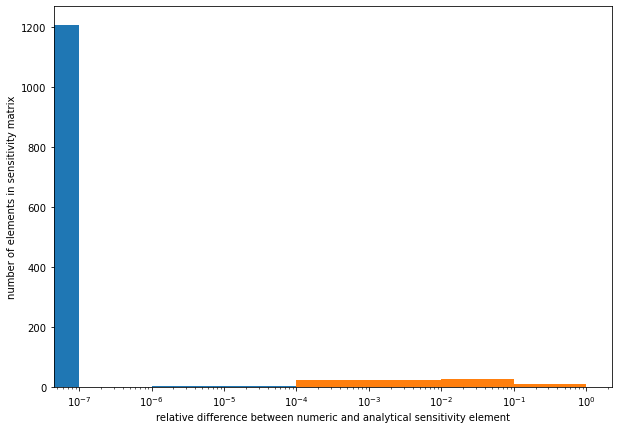

In [6]:
from database_reading import read_gma_database
from GMAP import run_GMA_program

from inference_new import (extract_predictions, extract_sensitivity_matrix,
        extract_covariance_matrix, extract_measurements, extract_prior_values)

from inference import (link_prior_and_datablocks, add_compinfo_to_datablock,
        fill_AA_AM_COV, update_all_estimates)

from database_writing_utils import (extract_prior_datatable,
        extract_experiment_datatable, extract_fission_datatable)

from gmap_snippets import label_to_MT

import pandas as pd
import numpy as np
import os


# load the database and reduce it to the reactions in the Mannhart evaluation
orig_dbfile = '../tests/test_002/input/data.gma'
db = read_gma_database(orig_dbfile)
datablock_list = db['datablock_list']
fisdata = db['fisdata']
APR = db['APR']
MPPP = db['MPPP']

# prepare the datastructures
link_prior_and_datablocks(APR, datablock_list)

# calculate sensitivity information and correlation matrices
for datablock in datablock_list:
    add_compinfo_to_datablock(datablock, fisdata, APR, MPPP)

# examples of extracting information
priorvals = extract_prior_values(APR)
preds = extract_predictions(datablock_list)
meas = extract_measurements(datablock_list)
predvec = preds[:, np.newaxis]
S = extract_sensitivity_matrix(datablock_list, APR)
covmat = extract_covariance_matrix(datablock_list)


# functions to calculate predictions and analytic gradient (sensitivity matrix)

def get_predictions(priorvals):
    update_all_estimates(APR, priorvals)
    for data in datablock_list:
        fill_AA_AM_COV(data, fisdata, APR)
    preds = extract_predictions(datablock_list)
    return preds

def get_sensmat(priorvals):
    update_all_estimates(APR, priorvals)
    for data in datablock_list:
        fill_AA_AM_COV(data, fisdata, APR)
    sensmat = extract_sensitivity_matrix(datablock_list, APR)
    return sensmat


# function for numerical differentiation
def numdiff(func, x0, h=1e-6, idcs=None):
    y0 = func(x0)
    numinp = len(x0)
    numout = len(y0)
    jac = np.zeros((numout, len(idcs)))
    for i, idx in enumerate(idcs):
        xdelta = np.zeros(numinp)
        xdelta[idx] = h
        senscol = (-func(x0+2*xdelta) + 8*func(x0+xdelta) - 8*func(x0-xdelta) + func(x0-2*xdelta)) / (12*h)
        jac[:, i] = senscol
    return jac
        

# randomly check the sensitivies to hundred prior values
np.random.seed(44)
# np.random.seed(43)
paridcs = np.sort(np.unique(np.random.randint(0,len(priorvals),100)))
import time
start_time = time.time()
numS = numdiff(get_predictions, priorvals, idcs=paridcs)
anaS = get_sensmat(priorvals)
end_time = time.time()
print('time taken %s' % (end_time-start_time))


# analyze the results

redanaS = anaS[:,paridcs].toarray()
reldiff = np.abs(redanaS - numS)/ np.maximum(np.abs(redanaS),np.abs(numS)) 
absdiff = np.abs((redanaS - numS))


from matplotlib import pyplot as plt
idcs = np.where(redanaS != 0)  # 1e-6
fig, ax = plt.subplots(figsize=(10,7))
ax.hist(reldiff[idcs], bins=[0,1e-7,1e-6, 1e-4])
ax.hist(reldiff[idcs], bins=[1e-4, 1e-2, 1e-1, 1e-1, 1])
plt.xscale('log')
plt.xlabel('relative difference between numeric and analytical sensitivity element')
plt.ylabel('number of elements in sensitivity matrix')
plt.show()



In [9]:

#strange_idcs = np.where(np.logical_and(reldiff > 1e-3, relredanaS > 1e-3))   
strange_idcs = np.where(np.logical_and(reldiff > 1e-6, redanaS > 0))   
strange_idcs
redanaS[strange_idcs[0],strange_idcs[1]]

prior_dt = extract_prior_datatable(db['APR'])
fission_dt = extract_fission_datatable(db['fisdata'])
expdata_dt = extract_experiment_datatable(datablock_list, prior_dt)

dt1 = prior_dt.loc[strange_idcs[1]]
dt2 = expdata_dt.loc[strange_idcs[0]]
dt1.reset_index(inplace=True, drop=True)
dt2.reset_index(inplace=True, drop=True)
dt = pd.concat([dt1,dt2], axis=1)
dt['ana_sensel'] = redanaS[strange_idcs[0], strange_idcs[1]]
dt['num_sensel'] = numS[strange_idcs[0], strange_idcs[1]]
#dt['relsensel1'] = relredanaS[strange_idcs[0], strange_idcs[1]]
#dt['relsensel2'] = relnumS[strange_idcs[0], strange_idcs[1]]
dt['reldiff'] = dt['ana_sensel'] / dt['num_sensel'] - 1
del dt['reac2']
del dt['reac3']
dt


,xsid,reac,energy,xs,author,reference,dataset_id,energy,measurement,obstype,reac1,ana_sensel,num_sensel,reldiff
0,1,"6Li(n,a)",0.375,0.6620,M.C.DAVIS ET AL.,"ANE5,583(1978)",565,0.15,1.215,fission_average,"U5(n,f)",0.000001,0.000002,-0.027434
1,1,"6Li(n,a)",0.400,0.5640,M.C.DAVIS ET AL.,"ANE5,583(1978)",565,0.15,1.215,fission_average,"U5(n,f)",0.000178,0.000192,-0.075540
2,1,"6Li(n,a)",0.425,0.4972,M.C.DAVIS ET AL.,"ANE5,583(1978)",565,0.15,1.215,fission_average,"U5(n,f)",0.001482,0.001481,0.000746
3,1,"6Li(n,a)",0.450,0.4484,M.C.DAVIS ET AL.,"ANE5,583(1978)",565,0.15,1.215,fission_average,"U5(n,f)",0.001234,0.001235,-0.000891
4,1,"6Li(n,a)",0.475,0.4123,M.C.DAVIS ET AL.,"ANE5,583(1978)",565,0.15,1.215,fission_average,"U5(n,f)",0.008122,0.008097,0.003111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,1,"6Li(n,a)",0.960,0.2401,I.G.SCHROEDER ET AL.,84GEEL+PC,614,1.50,1.844,fission_average,"PU9(n,f)",0.040171,0.040205,-0.000823
63,1,"6Li(n,a)",0.980,0.2384,I.G.SCHROEDER ET AL.,84GEEL+PC,614,1.50,1.844,fission_average,"PU9(n,f)",0.032451,0.037190,-0.127429
64,1,"6Li(n,a)",1.000,0.2368,I.G.SCHROEDER ET AL.,84GEEL+PC,614,1.50,1.844,fission_average,"PU9(n,f)",0.055017,0.053165,0.034834
65,1,"6Li(n,a)",1.100,0.2303,I.G.SCHROEDER ET AL.,84GEEL+PC,614,1.50,1.844,fission_average,"PU9(n,f)",0.007844,0.008071,-0.028128
